# Nearest Neighbour algorithm

This is an implementation of the K-nearest neighbour algorithm, which decides the label of a sample by looking at its nearest neighbour.

First, we take care of all the imports

In [174]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statistics import mode

In [175]:
from sklearn.model_selection import train_test_split

In [176]:
iris = load_iris()

Before we go any further, let us split the iris dataset into training and test sets so that the accuracy of our nearest neighbour model can later be measured

In [177]:
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=307)

In [178]:
X_train.shape

(112, 4)

In [179]:
X_test.shape

(38, 4)

Let us first write the code to calculate the euclidean distance between two vectors _test_ and _train_

In [180]:
def euclidean(train, test):
    squares = [(x-y)**2 for (x,y) in zip(train,test)]
    return np.sqrt(np.sum(squares))

We need code to calculate the distances of a particular test sample from all the points in the training dataset

In [181]:
def calcDistance(X_train,testSample):
    distance=[]
    for x in X_train:
        distance.append(euclidean(x, testSample))
    return pd.DataFrame(data=distance,columns=['distance'])

We will find the distances to K nearest neighbors for this particular test sample

In [182]:
def getNearestNeighborDistances(k,X_train,testSample):
    distances=calcDistance(X_train,testSample)
    nearestNeighborDistances=distances['distance'].nsmallest(k,keep='last')
    return (nearestNeighborDistances)

From these distances, we need to find the labels for the nearest neighbors and use them to find the label of the test sample's prediction

In [183]:
def getLabel(distances,y_train):
    labels=[]
    for index,distance in distances.items():
        labels.append(y_train[index])
    return(mode(labels))

def getPredictionLabel(k,X_train,testSample,y_train):
    distances=getNearestNeighborDistances(k,X_train, testSample)
    return getLabel(distances,y_train)

Now we put down the overarching KNN function that we can use to calculate the predictions for the test set

In [184]:
def KNearestNeighbors(k,X_train,X_test,y_train,y_test):
    predictions = []
    for testSample in X_test:
        predictions.append(getPredictionLabel(k,X_train,testSample,y_train))
    return predictions

Looks good so far - let us test this with K=1

In [185]:
predictions=KNearestNeighbors(1,X_train,X_test,y_train,y_test)
print(predictions)

[2, 2, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 1, 0, 2, 1]


Looks like we've made some predictions. Now let us count the number of errors our classifier has made.

In [186]:
def getErrors(predictions):
    errorCount=0
    for i in range(len(predictions)):
        if(predictions[i]!=y_test[i]):
            errorCount+=1
    errorRate=errorCount/len(y_test)
    return[errorCount,errorRate]

getErrors(predictions)

[2, 0.05263157894736842]

This looks like a good enough performance for K=1. Now let us try it for a higher K.

In [187]:
predictions3NN=KNearestNeighbors(3,X_train,X_test,y_train,y_test)
getErrors(predictions3NN)

[2, 0.05263157894736842]

Now let us map the error rate as a function of K

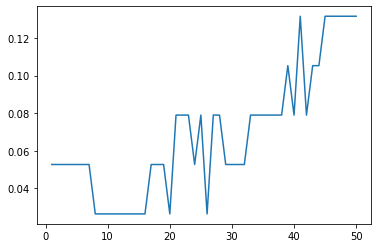

In [188]:
errorRates=[]
K_max=50
results = np.empty(K_max)
for k in range(K_max):
    preds=KNearestNeighbors(k+1,X_train,X_test,y_train,y_test)
    results[k] = getErrors(preds)[1]
plt.plot(np.arange(K_max)+1, results)

As we can see, the error rate of our predictor is the lowest between K=8 and K=16 and then a couple of other specific values of K

Let us now test our classifier with the ionosphere dataset

In [189]:
X = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=np.arange(34))
y = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=34, dtype="int")

In [190]:
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X, y, random_state=307)

Let us plot the same graph as above for the ionosphere data

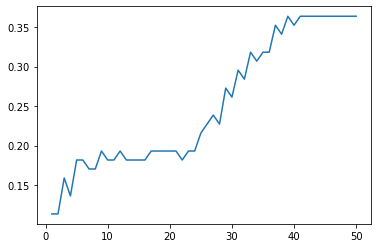

In [191]:
def getIonosphereErrors(predictions):
    errorCount=0
    for i in range(len(predictions)):
        if(predictions[i]!=y_i_test[i]):
            errorCount+=1
    errorRate=errorCount/len(y_i_test)
    return[errorCount,errorRate]

errorRates=[]
K_max=50
results = np.empty(K_max)
for k in range(K_max):
    preds=KNearestNeighbors(k+1,X_i_train,X_i_test,y_i_train,y_i_test)
    results[k] = getIonosphereErrors(preds)[1]
plt.plot(np.arange(K_max)+1, results)

In [194]:
results[0]

0.11363636363636363

In [195]:
results[2]

0.1590909090909091

As we can see, our error rate sits at an acceptable 0.15 or so around k=3 to k=5

# Conformal Prediction

Let us start by modifying the distance function for conformal prediction

In [196]:
def getNearestDistance(labelSamples, sample):
    distances=calcDistance(labelSamples,sample)
    return distances['distance'].min()

Now, let us look at how to calculate the conformity scores

In [197]:
def getConformityDistances(sameLabelSamples, diffLabelSamples, sample):
    sameDistance = getNearestDistance(sameLabelSamples, sample)
    diffDistance=getNearestDistance(diffLabelSamples, sample)
    return (sameDistance, diffDistance)

def splitSet(trainingSamples,trainingLabels, sampleLabel):
    sameLabelSamples = [x for x,y in zip(trainingSamples, trainingLabels) if y==sampleLabel]
    diffLabelSamples = [x for x,y in zip(trainingSamples, trainingLabels) if y!=sampleLabel]
    return (sameLabelSamples, diffLabelSamples)

def getConformityScores(extendedSet,extendedLabels):
    conScores = []
    for sample, index in zip(extendedSet,range(len(extendedLabels))):
        trainingSet = np.delete(extendedSet,index,axis=0)
        trainingLabels = np.delete(extendedLabels,index)
        sampleLabel = extendedLabels[index]
        (sameLabelSamples, diffLabelSamples) = splitSet(trainingSet,trainingLabels, sampleLabel)
        (sameDistance, diffDistance) = getConformityDistances(sameLabelSamples, diffLabelSamples, sample)
        conScore = diffDistance/sameDistance if sameDistance !=0 else np.Inf
        conScores.append(conScore)
    return conScores

And how to calculate the P values from the conformity scores

In [198]:
def rankData(a):
    u, v = np.unique(a, return_inverse=True)
    return (np.cumsum(np.bincount(v)) - 1)[v] + 1

def getPValues(X_train, testSample, y_train):
    extendedSet=np.vstack((X_train,testSample))
    pValues = {'pValues': []}
    for assumedLabel in list(set(y_train)):
        extendedLabels = np.append(y_train, assumedLabel)
        conScores = getConformityScores(extendedSet,extendedLabels)
        ranks = rankData(conScores)
        pValues[assumedLabel] = [i / len(conScores) for i in ranks[0:-1]]
        pValues['pValues'].append(ranks[-1] / len(conScores))
    return(pValues)  

Finally, let us figure out how to calculate the average false p values

In [199]:
def getAvgFalsePValues(pValues):
    avgFalsePValues = []
    for value in pValues:
        value.remove(max(value))
        avgFalsePValues.append(value)
    return np.average(avgFalsePValues)

Time to test this out

In [200]:
def conformalPrediction(X_train, X_test, y_train):
    pValuesForLabels = []
    for testSample in X_test:
        pValuesForLabels.append(getPValues(X_train, testSample, y_train))
    pValues=[i['pValues'] for i in pValuesForLabels]
    avgFalsePValues = getAvgFalsePValues(pValues)
    print(avgFalsePValues)

We'd earlier imported the iris dataset - let us test our conformal prediction nearest neighbour predictor on the same first.

In [201]:
conformalPrediction(X_train, X_test, y_train)

0.010130414531904984


This looks about right - now let us test the same on the ionosphere dataset that we imported from the txt file

In [202]:
conformalPrediction(X_i_train, X_i_test, y_i_train)

0.037017906336088154


Here's our average false p value for the ionosphere dataset - though this took a little longer to calculate than iris.